# Train a MLP on the BERT embeddings

In [23]:
from architectures.load_BERT_embeddings import load_BERT_embedding
from data import load_sequences

from tqdm import tqdm
import numpy as np
import csv
import pickle
import copy


import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### 1: Load Data, load embeddings, split train-val

In [2]:
# Sequence data
sequences_train, sequences_test, proteins_test, y_train = load_sequences(path="data/")


_, embeddings_train = load_BERT_embedding(path='data/bert_embeddings/train/embeddings.pkl')
_, embeddings_test = load_BERT_embedding(path='data/bert_embeddings/test/embeddings.pkl')

In [3]:
class proteins_dataset(Dataset):
    def __init__(self, embeddings, labels=None, train=False):
        self.embeddings = embeddings
        self.labels = labels
        self.train = train
    def __len__(self):
        return len(self.embeddings)
    def __getitem__(self, idx):
        x = torch.FloatTensor(self.embeddings[idx])
        if self.train:
            return x, self.labels[idx]
        else:
            return x

In [4]:
dataset_train = proteins_dataset(embeddings_train, y_train, train=True)
dataset_test = proteins_dataset(embeddings_test, train=False)

In [5]:
num_train = int(0.8 * len(dataset_train))
num_val = len(dataset_train) - num_train

train_set, val_set = torch.utils.data.random_split(dataset_train, [num_train, num_val],
                                                   generator=torch.Generator().manual_seed(42))

In [25]:
batch_size = 32

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

#### T-sne visualization of the embeddings

In [13]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

X = np.array(embeddings_train)
X_tsne = TSNE(n_components=2).fit_transform(X)

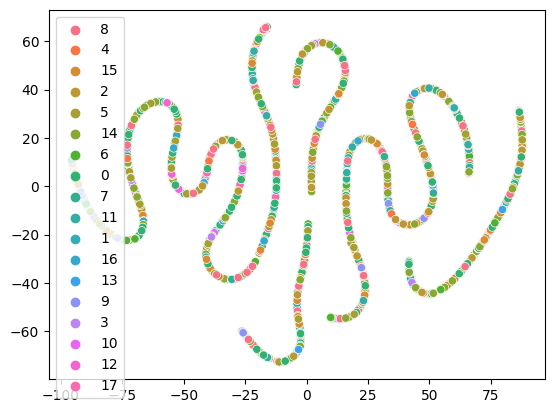

In [14]:
y = np.array(y_train, dtype=str)
import seaborn as sns
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y)
plt.show()

#### Baseline: linear logistic regression

In [27]:
from sklearn.linear_model import LogisticRegression

X_train = np.array(embeddings_train)
X_test = np.array(embeddings_test)

clf = LogisticRegression(solver='liblinear')
clf.fit(X_train, y_train) 
y_pred_proba = clf.predict_proba(X_test)

In [28]:
# Write predictions to a file
with open('submissions/BERT_protein.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    lst = list()
    for i in range(18):
        lst.append('class'+str(i))
    lst.insert(0, "name")
    writer.writerow(lst)
    for i, protein in enumerate(proteins_test):
        lst = y_pred_proba[i,:].tolist()
        lst.insert(0, protein)
        writer.writerow(lst)


###  Training and evaluation loops

In [17]:
def evaluate_accuracy(data_loader, verbose=True):
    model.eval()
    total_loss = 0.0
    ncorrect = ntotal = 0
    with torch.no_grad():
        for img, target in data_loader:
            # inference
            output = model(img.to(device))
            # total number of examples
            ntotal +=  output.shape[0]
            # number of correct predictions 
            _, predictions = torch.max(output, 1)
            #print('predictions: ', predictions)
            label = target.to(device)
            #print('Truth: ', label)
            ncorrect += torch.sum(predictions==label)
        acc = ncorrect.item() / ntotal
        if verbose:
          print("validation accuracy: {:3.2f}".format(acc*100))
        return acc

In [18]:
def train():
    best_validation_acc = 0.0
    p = 0 # patience
    
    for epoch in range(1, nb_epochs + 1):
        losses = []
        accuracies = []
        with tqdm(train_loader, unit='batch') as tepoch:
            for img, target in tepoch:
                tepoch.set_description(f"Epoch {epoch}")
                model.train()
                optimizer.zero_grad()
                data = img.to(device)
                label = target.to(device)
                output = model.forward(data)
                loss = criterion(output, label)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
                optimizer.step()
                
                losses.append(loss.item())
                _, predictions = torch.max(output, 1)
                accuracy = torch.sum(predictions == label).item() / batch_size
                accuracies.append(accuracy)
                tepoch.set_postfix(loss=sum(losses)/len(losses), accuracy=100. * sum(accuracies)/len(accuracies))
        train_acc = evaluate_accuracy(train_loader, False)
        val_acc = evaluate_accuracy(val_loader, False)
        print("===> Epoch {} Complete: Avg. Loss: {:.4f}, Validation Accuracy: {:3.2f}%"
              .format(epoch, sum(losses)/len(losses), 100.*val_acc))
        torch.save(model.state_dict(), './model_epoch_{}.pt'.format(epoch))
        if val_acc >= best_validation_acc:
            best_validation_acc = val_acc
            print("Validation accuracy improved, saving model...")
            torch.save(model.state_dict(), './best_model.pt')
            p = 0
            print()
        else:
            p += 1
            if p==my_patience:
                print("Validation accuracy did not improve for {} epochs, stopping training...".format(my_patience))
                break
        scheduler.step()
    print("Loading best checkpoint...")
    last_model = copy.deepcopy(model)
    model.load_state_dict(torch.load('./best_model.pt'))
    model.eval()
    print('done.')
    return last_model

### Define the model architecture

In [24]:
model = nn.Sequential(nn.Linear(1024, 512),
                         nn.ReLU(),
                         nn.Dropout(0.1),
                         nn.Linear(512, 18))

model = model.to(device)

### Train the model

In [26]:
lr= 0.1
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
#optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)
nb_epochs = 35
my_patience=15

last_model = train()

Epoch 1: 100%|██| 123/123 [00:00<00:00, 138.98batch/s, accuracy=12.9, loss=345]


===> Epoch 1 Complete: Avg. Loss: 344.5334, Validation Accuracy: 6.34%
Validation accuracy improved, saving model...



Epoch 2: 100%|█| 123/123 [00:00<00:00, 233.44batch/s, accuracy=14.7, loss=29.9]


===> Epoch 2 Complete: Avg. Loss: 29.8763, Validation Accuracy: 1.02%


Epoch 3: 100%|█| 123/123 [00:00<00:00, 302.70batch/s, accuracy=19.8, loss=3.36]


===> Epoch 3 Complete: Avg. Loss: 3.3625, Validation Accuracy: 21.37%
Validation accuracy improved, saving model...



Epoch 4: 100%|█| 123/123 [00:00<00:00, 305.26batch/s, accuracy=19.2, loss=2.36]


===> Epoch 4 Complete: Avg. Loss: 2.3612, Validation Accuracy: 21.37%
Validation accuracy improved, saving model...



Epoch 5: 100%|█| 123/123 [00:00<00:00, 311.52batch/s, accuracy=19.5, loss=2.36]


===> Epoch 5 Complete: Avg. Loss: 2.3613, Validation Accuracy: 18.40%


Epoch 6: 100%|█| 123/123 [00:00<00:00, 228.12batch/s, accuracy=19.2, loss=2.36]


===> Epoch 6 Complete: Avg. Loss: 2.3571, Validation Accuracy: 18.40%


Epoch 7: 100%|█| 123/123 [00:00<00:00, 287.79batch/s, accuracy=19.3, loss=2.52]


===> Epoch 7 Complete: Avg. Loss: 2.5237, Validation Accuracy: 21.37%
Validation accuracy improved, saving model...



Epoch 8: 100%|█| 123/123 [00:00<00:00, 307.56batch/s, accuracy=19.8, loss=3.97]


===> Epoch 8 Complete: Avg. Loss: 3.9702, Validation Accuracy: 18.40%


Epoch 9: 100%|█| 123/123 [00:00<00:00, 296.40batch/s, accuracy=17.9, loss=24.9]


===> Epoch 9 Complete: Avg. Loss: 24.9402, Validation Accuracy: 18.40%


Epoch 10: 100%|█| 123/123 [00:00<00:00, 260.97batch/s, accuracy=16.3, loss=53.7


===> Epoch 10 Complete: Avg. Loss: 53.6823, Validation Accuracy: 21.37%
Validation accuracy improved, saving model...



Epoch 11: 100%|█| 123/123 [00:00<00:00, 239.63batch/s, accuracy=15.3, loss=93.8


===> Epoch 11 Complete: Avg. Loss: 93.7949, Validation Accuracy: 10.84%


Epoch 12: 100%|█| 123/123 [00:00<00:00, 320.93batch/s, accuracy=14.4, loss=85.7


===> Epoch 12 Complete: Avg. Loss: 85.6752, Validation Accuracy: 1.02%


Epoch 13: 100%|█| 123/123 [00:00<00:00, 311.21batch/s, accuracy=15.8, loss=76.9


===> Epoch 13 Complete: Avg. Loss: 76.9190, Validation Accuracy: 21.37%
Validation accuracy improved, saving model...



Epoch 14: 100%|█| 123/123 [00:00<00:00, 321.49batch/s, accuracy=19.3, loss=24.8


===> Epoch 14 Complete: Avg. Loss: 24.7750, Validation Accuracy: 21.37%
Validation accuracy improved, saving model...



Epoch 15: 100%|█| 123/123 [00:00<00:00, 286.69batch/s, accuracy=15.1, loss=45.6


===> Epoch 15 Complete: Avg. Loss: 45.5557, Validation Accuracy: 18.40%


Epoch 16: 100%|█| 123/123 [00:00<00:00, 280.37batch/s, accuracy=18.9, loss=2.35


===> Epoch 16 Complete: Avg. Loss: 2.3460, Validation Accuracy: 18.40%


Epoch 17: 100%|█| 123/123 [00:00<00:00, 211.07batch/s, accuracy=19.4, loss=2.34


===> Epoch 17 Complete: Avg. Loss: 2.3422, Validation Accuracy: 21.37%
Validation accuracy improved, saving model...



Epoch 18: 100%|██| 123/123 [00:00<00:00, 304.07batch/s, accuracy=20, loss=2.34]


===> Epoch 18 Complete: Avg. Loss: 2.3426, Validation Accuracy: 21.37%
Validation accuracy improved, saving model...



Epoch 19: 100%|█| 123/123 [00:00<00:00, 318.14batch/s, accuracy=19.8, loss=2.34


===> Epoch 19 Complete: Avg. Loss: 2.3417, Validation Accuracy: 21.37%
Validation accuracy improved, saving model...



Epoch 20: 100%|█| 123/123 [00:00<00:00, 299.26batch/s, accuracy=19.7, loss=2.34


===> Epoch 20 Complete: Avg. Loss: 2.3445, Validation Accuracy: 18.40%


Epoch 21: 100%|█| 123/123 [00:00<00:00, 250.12batch/s, accuracy=19.4, loss=2.34


===> Epoch 21 Complete: Avg. Loss: 2.3430, Validation Accuracy: 18.40%


Epoch 22: 100%|██| 123/123 [00:00<00:00, 241.44batch/s, accuracy=20, loss=2.34]


===> Epoch 22 Complete: Avg. Loss: 2.3419, Validation Accuracy: 21.37%
Validation accuracy improved, saving model...



Epoch 23: 100%|██| 123/123 [00:00<00:00, 296.60batch/s, accuracy=20, loss=2.34]


===> Epoch 23 Complete: Avg. Loss: 2.3386, Validation Accuracy: 21.37%
Validation accuracy improved, saving model...



Epoch 24: 100%|█| 123/123 [00:00<00:00, 305.75batch/s, accuracy=19.8, loss=2.34


===> Epoch 24 Complete: Avg. Loss: 2.3405, Validation Accuracy: 18.40%


Epoch 25: 100%|█| 123/123 [00:00<00:00, 310.58batch/s, accuracy=19.2, loss=2.34


===> Epoch 25 Complete: Avg. Loss: 2.3387, Validation Accuracy: 21.37%
Validation accuracy improved, saving model...



Epoch 26: 100%|█| 123/123 [00:00<00:00, 277.20batch/s, accuracy=19.7, loss=2.34


===> Epoch 26 Complete: Avg. Loss: 2.3411, Validation Accuracy: 21.37%
Validation accuracy improved, saving model...



Epoch 27: 100%|█| 123/123 [00:00<00:00, 203.52batch/s, accuracy=19.8, loss=2.34


===> Epoch 27 Complete: Avg. Loss: 2.3433, Validation Accuracy: 21.37%
Validation accuracy improved, saving model...



Epoch 28: 100%|█| 123/123 [00:00<00:00, 321.68batch/s, accuracy=19.7, loss=2.34


===> Epoch 28 Complete: Avg. Loss: 2.3411, Validation Accuracy: 21.37%
Validation accuracy improved, saving model...



Epoch 29: 100%|█| 123/123 [00:00<00:00, 298.33batch/s, accuracy=20.2, loss=2.34


===> Epoch 29 Complete: Avg. Loss: 2.3424, Validation Accuracy: 18.40%


Epoch 30: 100%|█| 123/123 [00:00<00:00, 301.37batch/s, accuracy=19.7, loss=2.34


===> Epoch 30 Complete: Avg. Loss: 2.3387, Validation Accuracy: 18.40%


Epoch 31: 100%|█| 123/123 [00:00<00:00, 283.56batch/s, accuracy=19.2, loss=2.34


===> Epoch 31 Complete: Avg. Loss: 2.3374, Validation Accuracy: 21.37%
Validation accuracy improved, saving model...



Epoch 32: 100%|██| 123/123 [00:00<00:00, 234.40batch/s, accuracy=20, loss=2.34]


===> Epoch 32 Complete: Avg. Loss: 2.3449, Validation Accuracy: 21.37%
Validation accuracy improved, saving model...



Epoch 33: 100%|██| 123/123 [00:00<00:00, 302.31batch/s, accuracy=20, loss=2.34]


===> Epoch 33 Complete: Avg. Loss: 2.3390, Validation Accuracy: 21.37%
Validation accuracy improved, saving model...



Epoch 34: 100%|██| 123/123 [00:00<00:00, 275.69batch/s, accuracy=20, loss=2.34]


===> Epoch 34 Complete: Avg. Loss: 2.3399, Validation Accuracy: 21.37%
Validation accuracy improved, saving model...



Epoch 35: 100%|██| 123/123 [00:00<00:00, 292.12batch/s, accuracy=20, loss=2.34]


===> Epoch 35 Complete: Avg. Loss: 2.3423, Validation Accuracy: 21.37%
Validation accuracy improved, saving model...

Loading best checkpoint...
done.
